In [1]:
#### Load in data ####

import os
import cv2
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm
from utils import load_images_by_domain, split_images

# Define paths
img_dir = "../OfficeCaltechDomainAdaptation/images"

# Load images by domain
data_by_domain = load_images_by_domain(
    img_dir=img_dir,
    target_size=(300, 300),  # Standardized size
    method="pad",           # Use padding to maintain aspect ratio
    seed=888                # Seed for reproducibility
)

# Split images: Combine amazon and caltech10 into train/val/test
train_data, val_data, test_data = split_images(
    data_by_domain=data_by_domain,
    train_domains=["amazon", "caltech10"],  # Combine these for training and validation
    test_domains=[],                        # Use part of amazon and caltech10 for testing
    train_split=0.6,                        # 60% for training
    val_split=0.2,                          # 20% for validation
    use_train_for_test=True,                # Use part of train_domains for testing
    test_split=0.2,                         # 20% for testing
    seed=888                                # Seed for reproducibility
)

# Summary of splits
print(f"Train images: {len(train_data['images'])}, Train labels: {len(train_data['labels'])}")
print(f"Validation images: {len(val_data['images'])}, Validation labels: {len(val_data['labels'])}")
print(f"Test images: {len(test_data['images'])}, Test labels: {len(test_data['labels'])}")


Train images: 1247, Train labels: 1247
Validation images: 415, Validation labels: 415
Test images: 419, Test labels: 419


In [ ]:

# Import LBP function and grayscale conversion from utils
from utils import compute_multiscale_lbp_features, convert_to_grayscale

# Define LBP parameters
P_values = [8, 16, 24]  # Number of neighbors
R_values = [1, 2, 3]    # Radius
PR_combinations = list(product(P_values, R_values))  # All (P, R) combinations

def extract_lbp_features(split_data, PR_combinations):
    """
    Extract LBP features for all images in a data split.

    Args:
        split_data (dict): Dictionary with keys 'images' and 'labels'.
        PR_combinations (list of tuples): LBP (P, R) combinations.

    Returns:
        pd.DataFrame: DataFrame containing LBP features and labels.
    """
    features = []
    labels = split_data['labels']
    
    print(f"Extracting LBP features from {len(split_data['images'])} images...")
    
    for img in tqdm(split_data['images']):
        # Convert to grayscale
        img_gray = convert_to_grayscale(img)
        
        # Ensure image is in uint8 format
        if img_gray.dtype != np.uint8:
            if img_gray.max() <= 1.0:
                img_gray = (img_gray * 255).astype(np.uint8)
            else:
                img_gray = img_gray.astype(np.uint8)
        
        # Ensure image is 2D
        if img_gray.ndim != 2:
            raise ValueError(f"Image has {img_gray.ndim} dimensions after conversion to grayscale. Expected 2D.")
        
        # Extract LBP features
        lbp_features = compute_multiscale_lbp_features(img_gray, PR_combinations)
        
        features.append(lbp_features)
    
    # Create DataFrame
    feature_array = np.array(features)
    
    # Create descriptive feature names
    feature_columns = [f"LBP_feature_{i}" for i in range(feature_array.shape[1])]
    
    df = pd.DataFrame(feature_array, columns=feature_columns)
    df['label'] = labels
    return df

# Extract LBP features for each split
train_lbp_df = extract_lbp_features(train_data, PR_combinations)
val_lbp_df = extract_lbp_features(val_data, PR_combinations)
test_lbp_df = extract_lbp_features(test_data, PR_combinations)

# Save LBP features to CSV
train_lbp_df.to_csv('train_lbp_features.csv', index=False)
val_lbp_df.to_csv('val_lbp_features.csv', index=False)
test_lbp_df.to_csv('test_lbp_features.csv', index=False)

print("LBP feature extraction and saving completed successfully!")


In [ ]:
# Import GLCM function and grayscale conversion from utils
from utils import compute_glcm_features, convert_to_grayscale

# Define GLCM parameters
glcm_distances = [1, 2, 3]  # Multiple distances
glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°

def extract_glcm_features_split(split_data, glcm_distances, glcm_angles):
    """
    Extract GLCM features for all images in a data split.

    Args:
        split_data (dict): Dictionary with keys 'images' and 'labels'.
        glcm_distances (list): GLCM distances.
        glcm_angles (list): GLCM angles.

    Returns:
        pd.DataFrame: DataFrame containing GLCM features and labels.
    """
    features = []
    labels = split_data['labels']
    
    print(f"Extracting GLCM features from {len(split_data['images'])} images...")
    
    for img in tqdm(split_data['images']):
        # Convert to grayscale
        img_gray = convert_to_grayscale(img)
        
        # Ensure image is in uint8 format
        if img_gray.dtype != np.uint8:
            if img_gray.max() <= 1.0:
                img_gray = (img_gray * 255).astype(np.uint8)
            else:
                img_gray = img_gray.astype(np.uint8)
        
        # Ensure image is 2D
        if img_gray.ndim != 2:
            raise ValueError(f"Image has {img_gray.ndim} dimensions after conversion to grayscale. Expected 2D.")
        
        # Extract GLCM features
        glcm_features = compute_glcm_features(img_gray, glcm_distances, glcm_angles)
        
        features.append(glcm_features)
    
    # Create DataFrame
    feature_array = np.array(features)
    
    # Create descriptive feature names
    feature_columns = [f"GLCM_feature_{i}" for i in range(feature_array.shape[1])]
    
    df = pd.DataFrame(feature_array, columns=feature_columns)
    df['label'] = labels
    return df

# Extract GLCM features for each split
train_glcm_df = extract_glcm_features_split(train_data, glcm_distances, glcm_angles)
val_glcm_df = extract_glcm_features_split(val_data, glcm_distances, glcm_angles)
test_glcm_df = extract_glcm_features_split(test_data, glcm_distances, glcm_angles)

# Save GLCM features to CSV
train_glcm_df.to_csv('train_glcm_features.csv', index=False)
val_glcm_df.to_csv('val_glcm_features.csv', index=False)
test_glcm_df.to_csv('test_glcm_features.csv', index=False)

print("GLCM feature extraction and saving completed successfully!")

In [ ]:
# Import Gabor function and grayscale conversion from utils
from utils import compute_gabor_features, convert_to_grayscale

# Define Gabor parameters
gabor_frequencies = [0.05, 0.1, 0.2, 0.3, 0.5]
gabor_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] 

def extract_gabor_features_split(split_data, gabor_frequencies, gabor_angles):
    """
    Extract Gabor features for all images in a data split.

    Args:
        split_data (dict): Dictionary with keys 'images' and 'labels'.
        gabor_frequencies (list): Gabor frequencies.
        gabor_angles (list): Gabor angles.

    Returns:
        pd.DataFrame: DataFrame containing Gabor features and labels.
    """
    features = []
    labels = split_data['labels']
    
    print(f"Extracting Gabor features from {len(split_data['images'])} images...")
    
    for img in tqdm(split_data['images']):
        # Convert to grayscale
        img_gray = convert_to_grayscale(img)
        
        # Ensure image is in uint8 format
        if img_gray.dtype != np.uint8:
            if img_gray.max() <= 1.0:
                img_gray = (img_gray * 255).astype(np.uint8)
            else:
                img_gray = img_gray.astype(np.uint8)
        
        # Ensure image is 2D
        if img_gray.ndim != 2:
            raise ValueError(f"Image has {img_gray.ndim} dimensions after conversion to grayscale. Expected 2D.")
        
        # Extract Gabor features
        gabor_feat = compute_gabor_features(img_gray, gabor_frequencies, gabor_angles)
        
        features.append(gabor_feat)
    
    # Create DataFrame
    feature_array = np.array(features)
    
    # Create descriptive feature names
    feature_columns = [f"Gabor_feature_{i}" for i in range(feature_array.shape[1])]
    
    df = pd.DataFrame(feature_array, columns=feature_columns)
    df['label'] = labels
    return df

# Extract Gabor features for each split
train_gabor_df = extract_gabor_features_split(train_data, gabor_frequencies, gabor_angles)
val_gabor_df = extract_gabor_features_split(val_data, gabor_frequencies, gabor_angles)
test_gabor_df = extract_gabor_features_split(test_data, gabor_frequencies, gabor_angles)

# Save Gabor features to CSV
train_gabor_df.to_csv('train_gabor_features.csv', index=False)
val_gabor_df.to_csv('val_gabor_features.csv', index=False)
test_gabor_df.to_csv('test_gabor_features.csv', index=False)

print("Gabor feature extraction and saving completed successfully!")


In [2]:
from utils import extract_resnet_features_split
import pandas as pd

# ResNet Feature Extraction
# Collect all labels from train, val, and test splits
train_labels_list = train_data['labels'].tolist() if isinstance(train_data['labels'], np.ndarray) else train_data['labels']
val_labels_list = val_data['labels'].tolist() if isinstance(val_data['labels'], np.ndarray) else val_data['labels']
test_labels_list = test_data['labels'].tolist() if isinstance(test_data['labels'], np.ndarray) else test_data['labels']

# Concatenate the label lists
all_labels = train_labels_list + val_labels_list + test_labels_list

# Get unique class names
unique_classes = sorted(set(all_labels))

# Create a mapping from class name to integer
label_to_int = {class_name: idx for idx, class_name in enumerate(unique_classes)}
int_to_label = {idx: class_name for class_name, idx in label_to_int.items()}

print("Label to integer mapping:", label_to_int)

# Function to convert labels in a data split
def convert_labels_to_int(split_data, label_to_int):
    split_data_int = split_data.copy()
    split_data_int['labels'] = [label_to_int[label] for label in split_data['labels']]
    return split_data_int

# Convert labels for each split
train_data_int = convert_labels_to_int(train_data, label_to_int)
val_data_int = convert_labels_to_int(val_data, label_to_int)
test_data_int = convert_labels_to_int(test_data, label_to_int)

# Proceed with feature extraction
num_classes = len(unique_classes)
train_resnet_df = extract_resnet_features_split(
    train_data_int, 'train', batch_size=16, num_classes=num_classes, int_to_label=int_to_label
)
val_resnet_df = extract_resnet_features_split(
    val_data_int, 'val', batch_size=16, num_classes=num_classes, int_to_label=int_to_label
)
test_resnet_df = extract_resnet_features_split(
    test_data_int, 'test', batch_size=16, num_classes=num_classes, int_to_label=int_to_label
)


Label to integer mapping: {'backpack': 0, 'bike': 1, 'calculator': 2, 'headphones': 3, 'keyboard': 4, 'laptop': 5, 'monitor': 6, 'mouse': 7, 'mug': 8, 'projector': 9}
Extracting ResNet features from 1247 images for 'train' split...


Extracting ResNet Features (train split): 100%|██████████| 78/78 [00:02<00:00, 37.66it/s]


ResNet feature extraction and saving completed for 'train' split. Saved to 'train_resnet_features.csv'.
Extracting ResNet features from 415 images for 'val' split...


Extracting ResNet Features (val split): 100%|██████████| 26/26 [00:00<00:00, 40.12it/s]


ResNet feature extraction and saving completed for 'val' split. Saved to 'val_resnet_features.csv'.
Extracting ResNet features from 419 images for 'test' split...


Extracting ResNet Features (test split): 100%|██████████| 27/27 [00:00<00:00, 39.93it/s]


ResNet feature extraction and saving completed for 'test' split. Saved to 'test_resnet_features.csv'.


c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


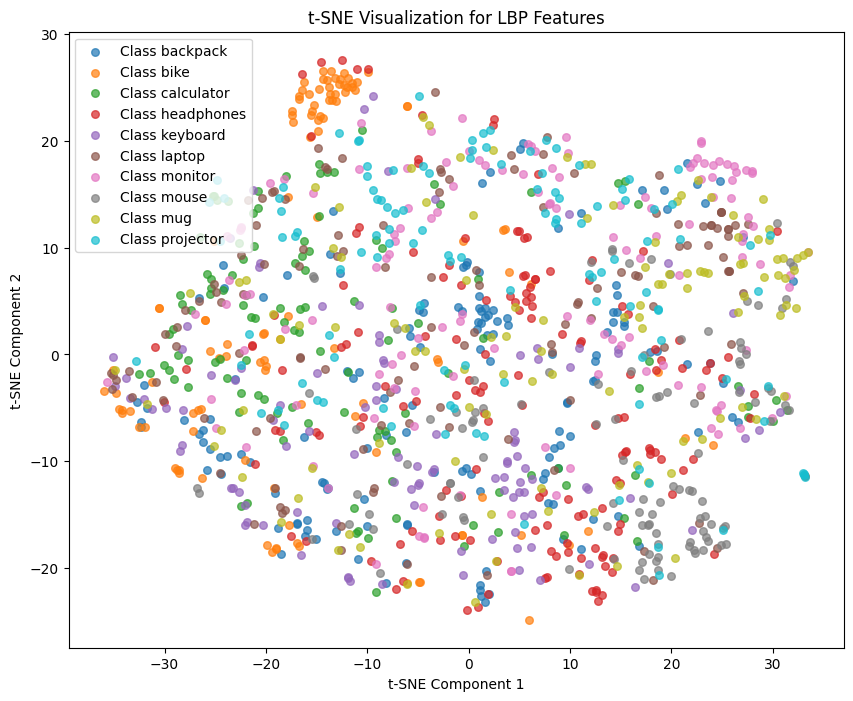

c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


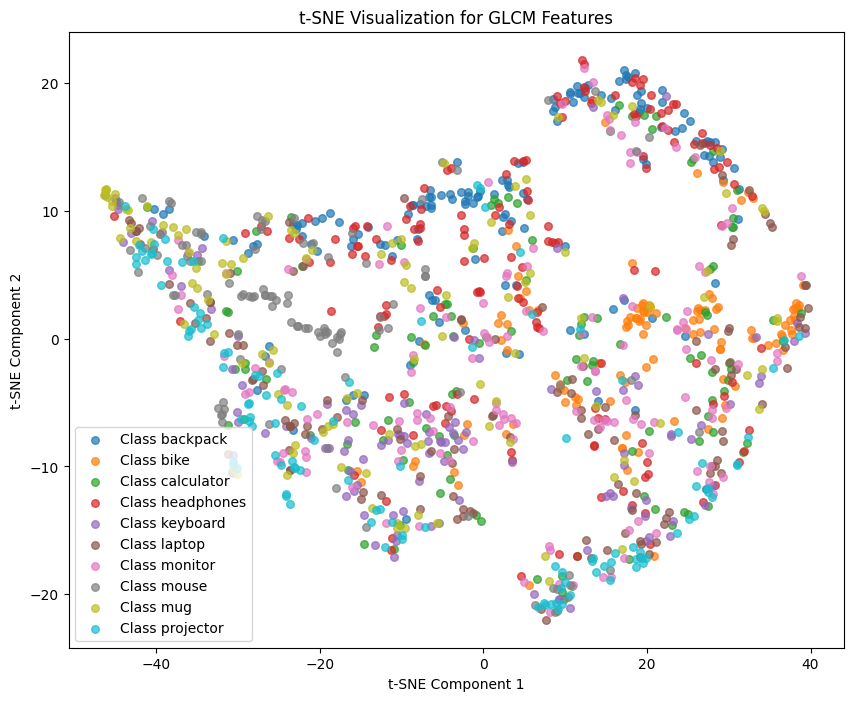

c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


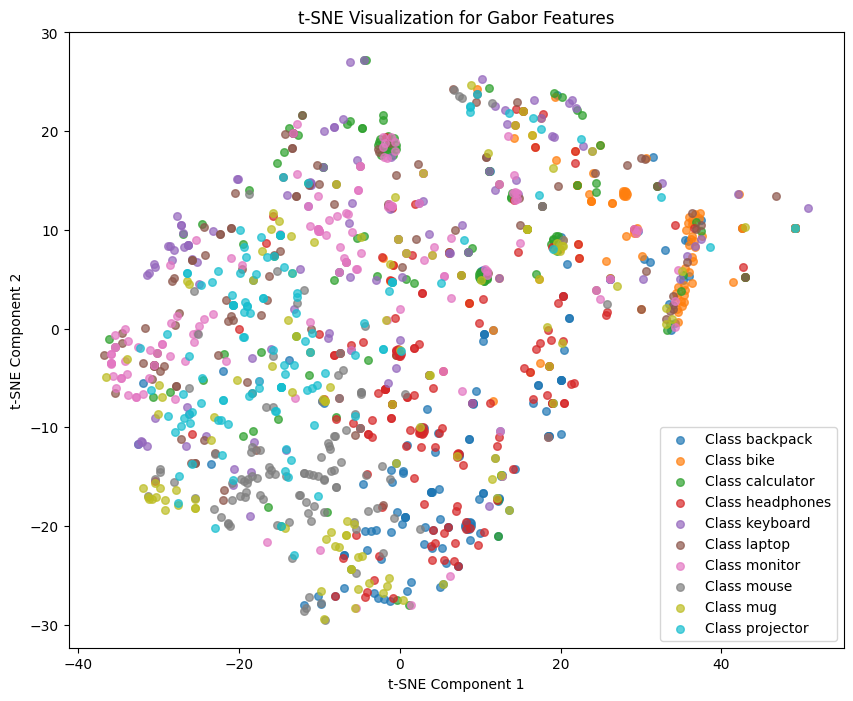

c:\Users\rockhopper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


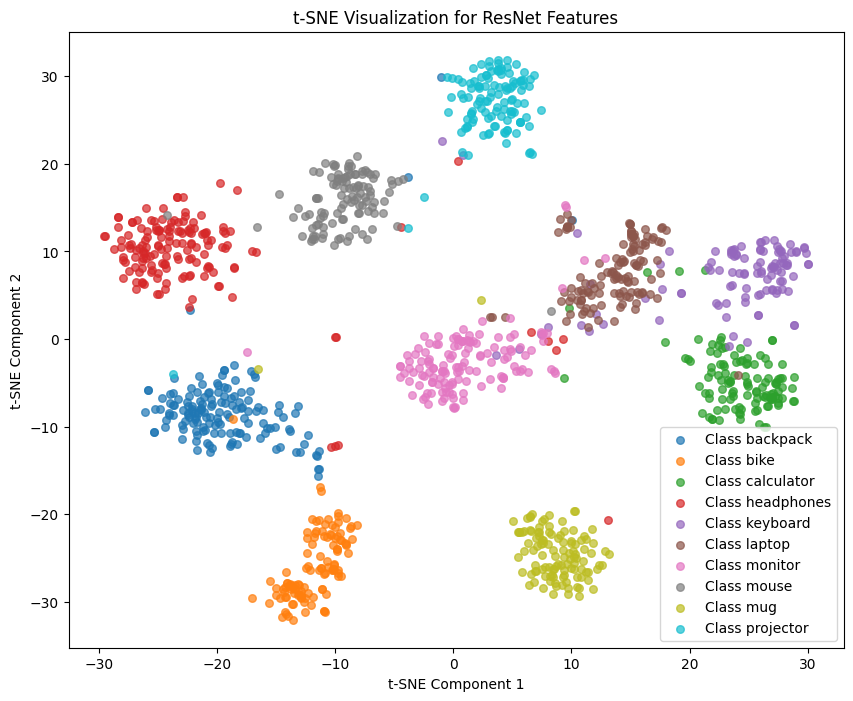

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load CSV files
file_paths = {
    "LBP": "train_lbp_features.csv",
    "GLCM": "train_glcm_features.csv",
    "Gabor": "train_gabor_features.csv",
    "ResNet": "train_resnet_features.csv"
}

datasets = {}

# Load datasets from CSV files
for method, path in file_paths.items():
    # Load the dataset
    df = pd.read_csv(path)
    # Extract features and labels
    features = df.drop(columns=["label"]).values
    labels = df["label"].values
    # Add to the datasets dictionary
    datasets[method] = (features, labels)

# Function to preprocess features
def preprocess_features(features):
    # Replace infinity and NaN values
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    # Clip values to a reasonable range
    features = np.clip(features, -1e6, 1e6)
    return features

# Preprocess features for all datasets
for method in datasets:
    features, labels = datasets[method]
    datasets[method] = (preprocess_features(features), labels)

# Function to apply t-SNE
def apply_tsne(features):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    features_2d = tsne.fit_transform(features)
    return features_2d

# Plot t-SNE results for each method
for method, (features, labels) in datasets.items():
    # Apply t-SNE
    features_2d = apply_tsne(features)
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    for category_id in np.unique(labels):
        idxs = np.where(labels == category_id)
        plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1], 
                    label=f"Class {category_id}", alpha=0.7, s=30)
    
    plt.legend()
    plt.title(f"t-SNE Visualization for {method} Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


Analyzing LBP...


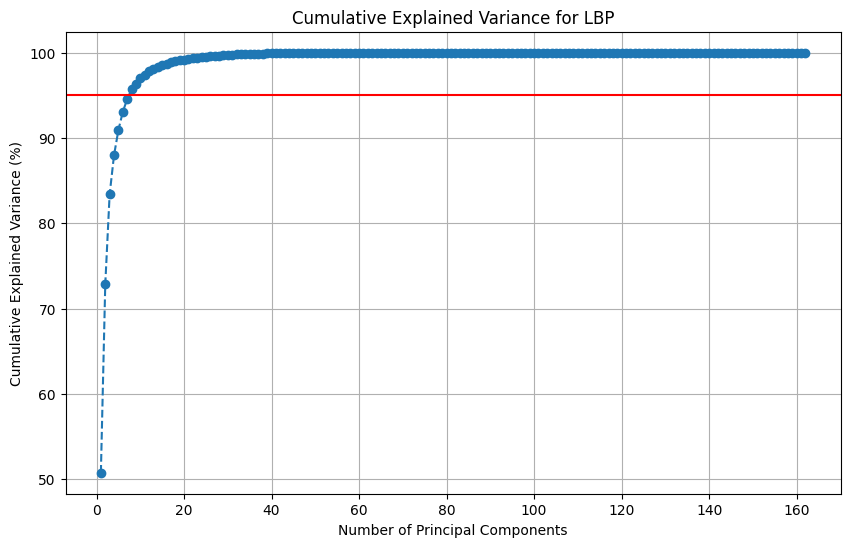

Number of components for 95% explained variance (LBP): 8
Analyzing GLCM...


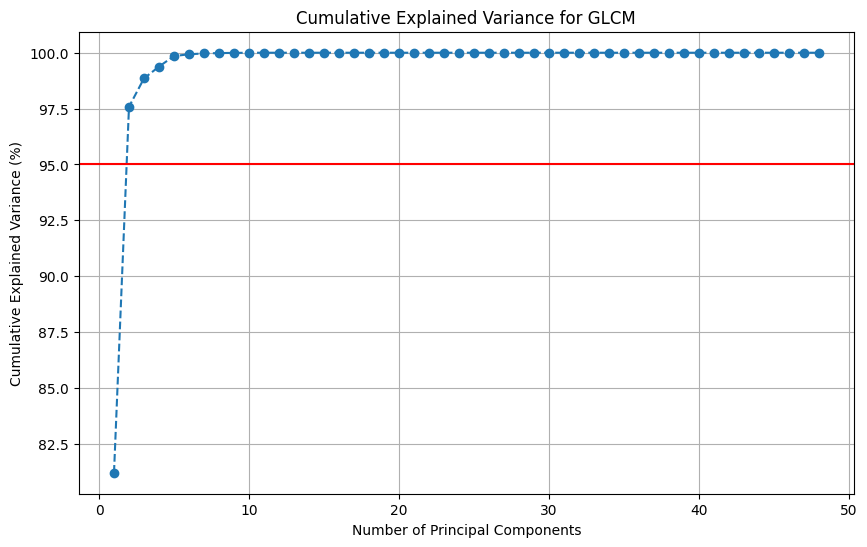

Number of components for 95% explained variance (GLCM): 2
Analyzing Gabor...


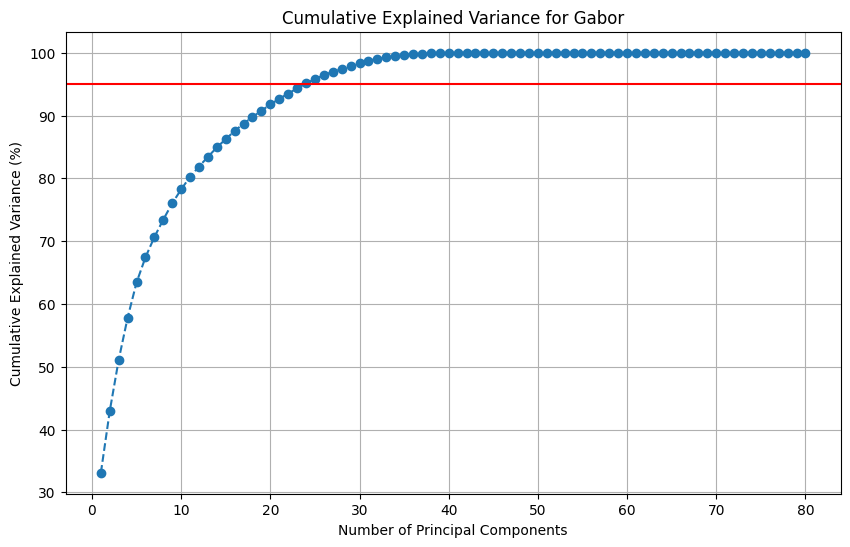

Number of components for 95% explained variance (Gabor): 24
Analyzing ResNet...


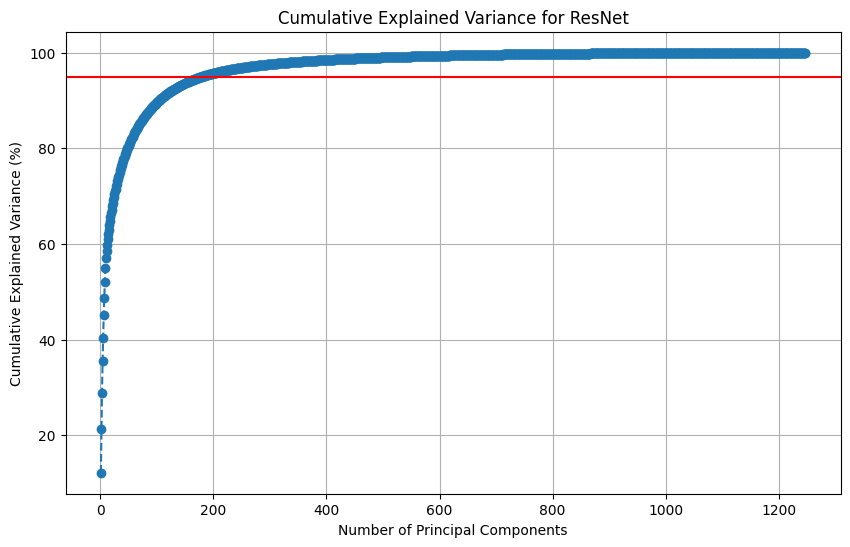

Number of components for 95% explained variance (ResNet): 180


In [8]:
from sklearn.decomposition import PCA  # Import PCA from sklearn

# Function to plot explained variance ratio
def plot_explained_variance(features, method_name):
    pca = PCA()  # PCA with all components
    pca.fit(features)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100

    # Plot the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(explained_variance_ratio) + 1),
        explained_variance_ratio,
        marker='o',
        linestyle='--',
    )
    plt.axhline(y=95, color='r', linestyle='-')
    plt.title(f"Cumulative Explained Variance for {method_name}")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.grid()
    plt.show()

    # Find the number of components to reach 95% variance
    n_components_95 = np.argmax(explained_variance_ratio >= 95) + 1
    print(f"Number of components for 95% explained variance ({method_name}): {n_components_95}")
    return n_components_95

# Visualize PCA explained variance for each method
for method, (features, _) in datasets.items():
    print(f"Analyzing {method}...")
    n_components = plot_explained_variance(features, method_name=method)


In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# File paths for features
file_paths = {
    "LBP": {
        "train": "train_lbp_features.csv",
        "val": "val_lbp_features.csv",
        "test": "test_lbp_features.csv",
    },
    "GLCM": {
        "train": "train_glcm_features.csv",
        "val": "val_glcm_features.csv",
        "test": "test_glcm_features.csv",
    },
    "Gabor": {
        "train": "train_gabor_features.csv",
        "val": "val_gabor_features.csv",
        "test": "test_gabor_features.csv",
    },
    "ResNet": {
        "train": "train_resnet_features.csv",
        "val": "val_resnet_features.csv",
        "test": "test_resnet_features.csv",
    },
}

# Step 1: Load features from CSV files
def load_features(file_paths):
    features = []
    labels = None

    for method, paths in file_paths.items():
        df = pd.read_csv(paths["train"])
        features.append(df.drop(columns=["label"]).values)  # Drop label column
        if labels is None:
            labels = df["label"].values  # Use labels from the first feature type
        else:
            assert np.array_equal(labels, df["label"].values), "Labels mismatch between features!"

    return np.hstack(features), labels  # Combine features horizontally and return labels

# Step 2: Clean invalid values in the features
def clean_features(features):
    """
    Cleans the input features by handling invalid values:
    - Replaces NaN with 0
    - Replaces +inf with 1e6 and -inf with -1e6
    - Clips extreme values to the range [-1e6, 1e6]
    """
    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)
    features = np.clip(features, -1e6, 1e6)
    return features

# Load and clean features
train_features, train_labels = load_features({k: v for k, v in file_paths.items()})
train_features = clean_features(train_features)

val_features, val_labels = load_features({k: {"train": v["val"]} for k, v in file_paths.items()})
val_features = clean_features(val_features)

test_features, test_labels = load_features({k: {"train": v["test"]} for k, v in file_paths.items()})
test_features = clean_features(test_features)

# Step 3: Normalize the training features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)

# Step 4: Fit PCA on training features
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
train_features_reduced = pca.fit_transform(train_features_normalized)

print(f"Number of components capturing 95% variance: {pca.n_components_}")

# Step 5: Transform validation and test features using the same PCA
val_features_normalized = scaler.transform(val_features)  # Use the same scaler
val_features_reduced = pca.transform(val_features_normalized)

test_features_normalized = scaler.transform(test_features)  # Use the same scaler
test_features_reduced = pca.transform(test_features_normalized)

# Step 6: Train an SVM model
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(train_features_reduced, train_labels)

# Step 7: Validate the model
val_predictions = svm_model.predict(val_features_reduced)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))

# Step 8: Test the model
test_predictions = svm_model.predict(test_features_reduced)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))


Number of components capturing 95% variance: 286
Validation Accuracy: 0.944578313253012
Validation Classification Report:
              precision    recall  f1-score   support

    backpack       0.94      0.98      0.96        49
        bike       1.00      0.97      0.99        40
  calculator       0.95      0.95      0.95        41
  headphones       0.89      0.98      0.93        43
    keyboard       0.85      0.90      0.88        39
      laptop       0.95      0.91      0.93        46
     monitor       0.95      0.93      0.94        42
       mouse       1.00      0.91      0.95        43
         mug       1.00      1.00      1.00        36
   projector       0.92      0.92      0.92        36

    accuracy                           0.94       415
   macro avg       0.95      0.94      0.94       415
weighted avg       0.95      0.94      0.94       415

Test Accuracy: 0.9498806682577565
Test Classification Report:
              precision    recall  f1-score   support

  

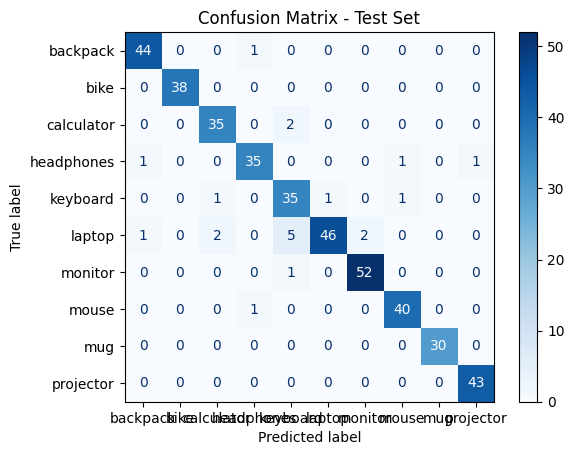

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix for the test set
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()
